<a href="https://colab.research.google.com/github/giedriusblazys/SDA_DS_class/blob/main/practice/decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Decision treas and Model explainability

In [1]:
#!pip install eli5
#!pip install pdpbox
#!pip install shop

**Data Source** https://www.kaggle.com/harlfoxem/housesalesprediction

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

**Column definitions** https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html
- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartments interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment,
- grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
- sqft_above - The square footage of the interior housing space that is above ground level
- sqft_basement - The square footage of the interior housing space that is below ground level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house’s last renovation
- zipcode - What zipcode area the house is in
- lat - Lattitude
- long - Longitude
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# improve how pandas numbers are displayed
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)

In [5]:
# load the data set
df = pd.read_csv("https://github.com/giedriusblazys/SDA_DS_class/blob/main/practice/input/kc_house_data.csv?raw=true")
# df = pd.read_csv("input/kc_house_data.csv")

In [6]:
type(df.date[0])

str

In [7]:
df.date = pd.to_datetime(df.date)
df['age'] = df.date.dt.year - df.yr_built

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [9]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
0,7129300520,2014-10-13,221900.000,3,1.000,1180,5650,1.000,0,0,3,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650,59
1,6414100192,2014-12-09,538000.000,3,2.250,2570,7242,2.000,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639,63
2,5631500400,2015-02-25,180000.000,2,1.000,770,10000,1.000,0,0,3,6,770,0,1933,0,98028,47.738,-122.233,2720,8062,82
3,2487200875,2014-12-09,604000.000,4,3.000,1960,5000,1.000,0,0,5,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000,49
4,1954400510,2015-02-18,510000.000,3,2.000,1680,8080,1.000,0,0,3,8,1680,0,1987,0,98074,47.617,-122.045,1800,7503,28


In [10]:
df['ln_price'] = np.log(df.price)

In [11]:
# use data for zip=98105 (University of Washington village)
idx_98105 = (df.zipcode == 98105)
df = df[idx_98105]
df['sql2'] = df.sqft_living * df.sqft_living

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
features = ['sqft_living',  'waterfront', 'view', 'grade', 'yr_built', 'age']
x = df[features]
y = df.ln_price
# y = df.price

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

def rmse(y_test, y_pred):
    """root mean squared error"""
    return round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)

def mae(y_test, y_pred):
    return round(mean_absolute_error(y_test, y_pred), 3)

def mape(y_test, y_pred):
    return round(mean_absolute_percentage_error(y_test, y_pred), 3)

def wmape(y_test, y_pred):
    wmape = sum(np.abs(y_test-y_pred)) / sum(np.abs(y_test))
    return round(wmape, 3)

In [14]:
# Let's use 70% of random sample to train the model, and the remaining 30% of sample to test how good is the model
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)

lr = LinearRegression()
reg = lr.fit(X_train, y_train)
y_pred = np.exp(reg.predict(X_test))
y_test_exp = np.exp(y_test)

print(f'Validation MAPE: {mape(y_test_exp, y_pred)}')
print(f'Validation WMAPE: {wmape(y_test_exp, y_pred)}')

print(f'Validation MAE: {mae(y_test_exp, y_pred)}')
print(f'Validation RMSE: {rmse(y_test_exp, y_pred)}')

Validation MAPE: 0.133
Validation WMAPE: 0.146
Validation MAE: 126358.452
Validation RMSE: 201112.44


In [15]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [16]:
import graphviz

In [17]:
dtr = DecisionTreeRegressor(random_state=42, max_depth=2, min_samples_split=5)
tree_model = dtr.fit(X_train, y_train)
y_pred = np.exp(tree_model.predict(X_test))
y_test_exp = np.exp(y_test)

print(f'Validation MAPE: {mape(y_test_exp, y_pred)}')
print(f'Validation WMAPE: {wmape(y_test_exp, y_pred)}')

print(f'Validation MAE: {mae(y_test_exp, y_pred)}')
print(f'Validation RMSE: {rmse(y_test_exp, y_pred)}')

Validation MAPE: 0.204
Validation WMAPE: 0.237
Validation MAE: 204838.613
Validation RMSE: 323486.749


Let's vizualize the tree

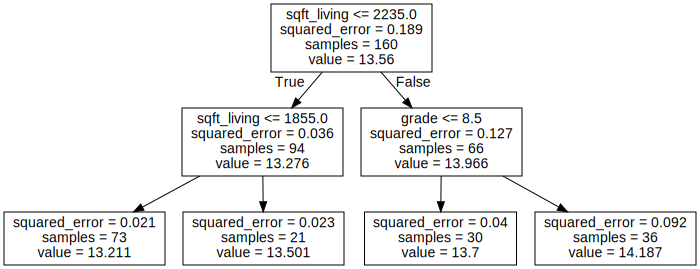

In [18]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)
graphviz.Source(tree_graph)

In [19]:
dtr = DecisionTreeRegressor(random_state=42, max_depth=6, min_samples_split=5)
tree_model = dtr.fit(X_train, y_train)
y_pred = np.exp(tree_model.predict(X_test))
y_test_exp = np.exp(y_test)

print(f'Validation MAPE: {mape(y_test_exp, y_pred)}')
print(f'Validation WMAPE: {wmape(y_test_exp, y_pred)}')

print(f'Validation MAE: {mae(y_test_exp, y_pred)}')
print(f'Validation RMSE: {rmse(y_test_exp, y_pred)}')

Validation MAPE: 0.156
Validation WMAPE: 0.172
Validation MAE: 148702.812
Validation RMSE: 233267.901


In [20]:
# Permutation Feature Importance

import eli5
from eli5.sklearn import PermutationImportance

In [21]:
perm = PermutationImportance(tree_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.7520 ± 0.3228,sqft_living
0.3853 ± 0.1035,grade
0.0284 ± 0.0206,view
0.0157 ± 0.0132,yr_built
-0.0007 ± 0.0257,age
-0.0026 ± 0.0000,waterfront


In [22]:
# Partial Dependence Plots
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


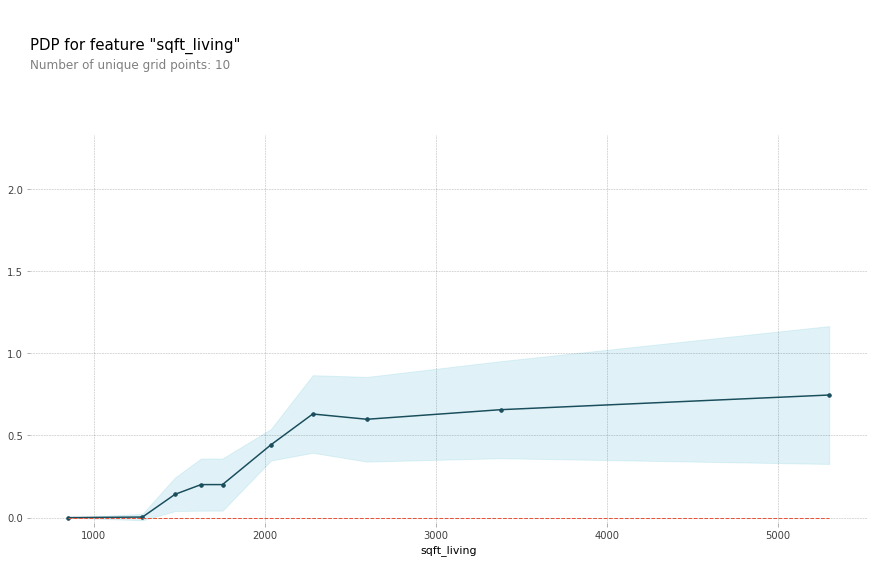

In [23]:
feature_to_plot = 'sqft_living'

pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=X_test, model_features=features, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

In [24]:
a = 100
b = 120

# let's estimate difference and percentage difference
print(f'b-a={b-a}')
print(f'(b-a)/a={(b-a)/a*100}%')

b-a=20
(b-a)/a=20.0%


In [25]:
ln_a = np.log(a)
ln_b = np.log(b)

print(f'ln_b-ln_a={(ln_b-ln_a)*100}')

ln_b-ln_a=18.2321556793954
